[Orignal paper](https://arxiv.org/abs/1502.03167)

In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm
from MyHelper import *
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
downloadData(filename,loc)

In [4]:
X,y=getData(filename,loc,flat=False)

In [5]:
print(X.shape,y.shape)

(60000, 28, 28, 1) (60000, 10)


In [6]:
img_size,nchannels = X.shape[1],X.shape[-1]
print(img_size)

28


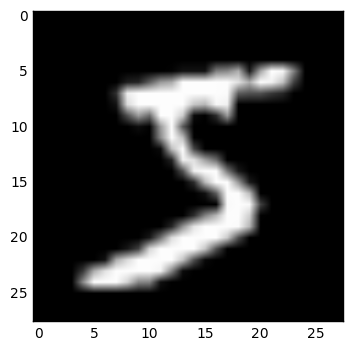

In [7]:
plt.imshow(X[0,:,:,0],cmap='gray')

# Model

<img src="images/discrim-architecture.png" width = "50%">

In [8]:
def createWeight(size):
    return tf.Variable(tf.truncated_normal(size, stddev=0.1))

def createBias(size):
    return tf.Variable(tf.constant(0.1,shape=size))

def lrelu(x, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x)

## No batch norm

In [9]:
batch_size = 32
g = tf.Graph()
with g.as_default():
    img_input = tf.placeholder(tf.float32,shape=(batch_size,img_size,img_size,nchannels))
    targets = tf.placeholder(tf.float32,shape=(batch_size,10))
    
    W_conv1 = createWeight([5,5,nchannels,64])
    b_conv1 = createWeight([64])
    
    W_conv2 = createWeight([5,5,64,128])
    b_conv2 = createWeight([128])
    
    W_logit = createWeight([128*7*7,10])
    b_logit = createWeight([10])
     
    #model
    conv1 = tf.nn.conv2d(img_input,W_conv1,strides=[1,2,2,1],padding="SAME")
    h1 = lrelu(conv1+b_conv1)
    
    conv2 = tf.nn.conv2d(h1,W_conv2,strides=[1,2,2,1],padding="SAME")
    h2 = lrelu(conv2+b_conv2)
    
    h2_s = tf.shape(h2)
    h2_flat = tf.reshape(h2,[batch_size,128*(h2_s[1])*(h2_s[2])]) #512*2*2
    
    logit = tf.matmul(h2_flat,W_logit)+b_logit

    
    #train
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit,targets))
    
    opt = tf.train.AdamOptimizer(learning_rate=.001).minimize(loss)
    
    train_accuracy = tf.reduce_mean(tf.cast(tf.equal(
        tf.arg_max(tf.nn.softmax(logit),1),tf.arg_max(targets,1)),tf.float32))
    
    init = tf.initialize_all_variables()

In [10]:
sess=tf.Session(graph=g)
sess.run(init)
losses = []

In [11]:
num_steps = 1001
for s in tqdm(range(num_steps)):
    fd = {img_input:X[(s*batch_size)%X.shape[0]:(s*batch_size+batch_size) % X.shape[0],:],
         targets:y[(s*batch_size)%y.shape[0]:(s*batch_size+batch_size)%y.shape[0],:]}
    l,_ = sess.run([loss,opt],feed_dict=fd)
    losses.append(l)
    if s % 100 == 0:
        print(sess.run([train_accuracy],feed_dict=fd))

  0%|          | 5/1001 [00:00<00:59, 16.77it/s]

[0.25]


 10%|█         | 104/1001 [00:04<00:35, 25.04it/s]

[0.78125]


 21%|██        | 206/1001 [00:08<00:30, 26.07it/s]

[0.875]


 30%|███       | 305/1001 [00:12<00:27, 24.93it/s]

[0.9375]


 40%|████      | 404/1001 [00:16<00:23, 24.98it/s]

[0.9375]


 51%|█████     | 506/1001 [00:20<00:18, 26.10it/s]

[0.875]


 60%|██████    | 605/1001 [00:24<00:15, 25.49it/s]

[1.0]


 70%|███████   | 704/1001 [00:27<00:11, 26.16it/s]

[1.0]


 80%|████████  | 803/1001 [00:31<00:08, 23.69it/s]

[0.9375]


 90%|█████████ | 905/1001 [00:36<00:03, 24.67it/s]

[1.0]


100%|██████████| 1001/1001 [00:40<00:00, 24.75it/s]

[0.9375]


In [12]:
p = figure(title="training loss", x_axis_label='train steps', y_axis_label='loss')
p.line(range(len(losses)),losses)
show(p)

## With Batch Norm

In [13]:
def createWeightsBN(s):
    """
    Creates weights for batch normalization layer
    
    Parameters:
    -----------
    s: int
        size of to be normalized
    """
    gamma = tf.Variable(tf.truncated_normal([s]))
    beta = tf.Variable(tf.ones([s]))
    return [gamma,beta]

def BN(x,variables,ri=[0,1,2],eps=.0001):
    """
    Applies Batch Normalization
    
    Parameters:
    ------------
    x: tensor
        the data to normalize
        
    variables: [gamma,beta]
        parameters to learn
        
    ri (optional): [int]
        reduction indicies
    eps (optional): float
        small number to keep from dividing by zero
    """
    gamma,beta = variables[0],variables[1]
    
    mu = tf.reduce_mean(x,ri,keep_dims=True)
    sigma = tf.reduce_mean(tf.square(x-mu),ri,keep_dims=True)
    x_hat = (x-mu)/(tf.sqrt(sigma+eps))
    y = gamma*x_hat+beta
    return y

In [14]:
batch_size = 32
g = tf.Graph()
with g.as_default():
    img_input = tf.placeholder(tf.float32,shape=(batch_size,img_size,img_size,nchannels))
    targets = tf.placeholder(tf.float32,shape=(batch_size,10))
    
    bn_input = createWeightsBN(nchannels)
    W_conv1 = createWeight([5,5,nchannels,64])
    b_conv1 = createWeight([64])
    
    bn_1 = createWeightsBN(64)
    W_conv2 = createWeight([5,5,64,128])
    b_conv2 = createWeight([128])
    
    bn_2 = createWeightsBN(128)
    W_logit = createWeight([128*7*7,10])
    b_logit = createWeight([10])
    bn_logit = createWeightsBN(10)
    
    #model
    img_input_bn = BN(img_input,bn_input)
    conv1 = tf.nn.conv2d(img_input_bn,W_conv1,strides=[1,2,2,1],padding="SAME")
    h1 = lrelu(conv1+b_conv1)
    
    h1_bn = BN(h1,bn_1)
    conv2 = tf.nn.conv2d(h1_bn,W_conv2,strides=[1,2,2,1],padding="SAME")
    h2 = lrelu(conv2+b_conv2)
    
    h2_bn = BN(h2,bn_2)
    h2_s = tf.shape(h2)
    h2_flat = tf.reshape(h2_bn,[batch_size,128*(h2_s[1])*(h2_s[2])]) #512*2*2

    logit = tf.matmul(h2_flat,W_logit)+b_logit
    logit_bn = BN(logit,bn_logit,ri=[0])

    
    #train
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logit_bn,targets))
    
    opt = tf.train.AdamOptimizer(learning_rate=.01).minimize(loss)
    
    train_accuracy = tf.reduce_mean(tf.cast(tf.equal(
        tf.arg_max(tf.nn.softmax(logit_bn),1),tf.arg_max(targets,1)),tf.float32))
    
    init = tf.initialize_all_variables()

In [15]:
h1_bn.get_shape()

TensorShape([Dimension(32), Dimension(14), Dimension(14), Dimension(64)])

In [16]:
sess=tf.Session(graph=g)
sess.run(init)
losses = []

In [17]:
num_steps = 1001
for s in tqdm(range(num_steps)):
    fd = {img_input:X[(s*batch_size)%X.shape[0]:(s*batch_size+batch_size) % X.shape[0],:],
         targets:y[(s*batch_size)%y.shape[0]:(s*batch_size+batch_size)%y.shape[0],:]}
    l,_ = sess.run([loss,opt],feed_dict=fd)
    losses.append(l)
    if s % 100 == 0:
        print(sess.run([train_accuracy],feed_dict=fd))

  0%|          | 3/1001 [00:00<01:45,  9.44it/s]

[0.53125]


 10%|█         | 103/1001 [00:08<01:06, 13.52it/s]

[0.875]


 20%|██        | 203/1001 [00:15<00:52, 15.18it/s]

[0.875]


 30%|███       | 303/1001 [00:21<00:46, 15.04it/s]

[0.96875]


 40%|████      | 403/1001 [00:28<00:39, 14.95it/s]

[0.9375]


 50%|█████     | 503/1001 [00:35<00:32, 15.46it/s]

[0.9375]


 60%|██████    | 603/1001 [00:42<00:27, 14.41it/s]

[1.0]


 70%|███████   | 703/1001 [00:48<00:22, 13.23it/s]

[0.9375]


 80%|████████  | 803/1001 [00:55<00:13, 15.21it/s]

[0.9375]


 90%|█████████ | 903/1001 [01:02<00:07, 13.08it/s]

[0.96875]


100%|██████████| 1001/1001 [01:08<00:00, 15.24it/s]

[0.9375]


In [18]:
p = figure(title="training loss", x_axis_label='train steps', y_axis_label='loss')
p = figure()
p.line(range(len(losses)),losses)
show(p)